## Pretrained models

### Torchvision

[torchvision](https://github.com/pytorch/vision) - библиотека, содержащая популярные CV датасеты, утилиты для препроцессинга и, самое важное, pre-trained модели для классификации, обученные на [ImageNet](http://image-net.org/).

Большая часть потребностей покрывается имеющимися моделями, но если нужна какая-то другая архитектура или нужно решать задачу, отличную от классификации, то хорошую реализацию и веса, скорее всего, получится нагуглить или найти на github

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [2]:
import os
from pathlib import Path
from copy import deepcopy
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
import torchvision
import torch
import torch.nn as nn
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/home/brodt/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
model = torchvision.models.resnet50(pretrained=True)
model.train(False)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Transfer learning

### Как достать признаки?

- переопределить последний слой так, чтобы он ничего не делал (неплохой вариант, но что, если нужны признаки из внутрненнего слоя?)
- написать хук, который будет возвращать признаки (хороший вариант)
- покромсать сетку и делать forward pass только для тех слоев, которые нужны (плохой вариант)


#### Способ 1. Переопределить последний слой

***ВНИМАНИЕ 1:*** Серьезная проблема `torchvision` - отсутствие единого интерфейса у моделей. В каждой реализации слои имеют разные имена и при единовременной работе с разными моделями приходится писать обвязку из условий. Если использовать реализации других архитектур, то ситуация только ухудшается

***ВНИМАНИЕ 2:*** В отличие от **Keras**, в **PyTorch** не принято делать последним слоем активацию. Нужная функция применяется при написании train / inference кода

In [4]:
model = torchvision.models.resnet50(pretrained=True)
features_model = deepcopy(model)

features_model.fc = nn.Identity()

dummy_x = torch.randn(1, 3, 224, 224)
features = features_model(dummy_x)
features_shape = features.data.numpy().shape
assert features_shape == (1, 2048), 'expected (1, 2048), but real is {}'.format(features_shape)

#### Способ 2. Forward hook

In [5]:
avgpool_features = None

def get_features(module, inputs, output):
    global avgpool_features   
    avgpool_features = np.squeeze(output.data.cpu().numpy(), axis=(2, 3))

model = torchvision.models.resnet50(pretrained=True)
model.avgpool.register_forward_hook(get_features)

dummy_x = torch.randn(1, 3, 224, 224)
model(dummy_x)

assert avgpool_features.shape == (1, 2048), 'expected (1, 2048), but real is {}'.format(avgpool_features.shape)

### Обучение на признаках

Обучим обычный sklearn-классификатор, которому на вход подадим признаки из нейросети

В качестве датасета будем использовать данные конкурса https://www.kaggle.com/c/dogs-vs-cats/data, https://www.tensorflow.org/datasets/catalog/cats_vs_dogs

Датасет содержит 25000 изображений кошек и собак, по 12500 каждого класса. Задача: определить, к какому классу относится конкретное изображение

Для определения качества моделей будем использовать метрику ROC-AUC

Скачаем и подготовим данные. Выделим 30% на валидацию

In [8]:
!wget -nc https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -f kagglecatsanddogs_3367a.zip

File ‘kagglecatsanddogs_3367a.zip’ already there; not retrieving.

Archive:  kagglecatsanddogs_3367a.zip


In [9]:
data_path = Path('PetImages')
cat_fnames = [str(p) for p in (data_path / 'Cat').glob('*.jpg')][:1000]
dog_fnames = [str(p) for p in (data_path / 'Dog').glob('*.jpg')][:1000]
all_names = cat_fnames + dog_fnames
labels = np.array([0] * len(cat_fnames) + [1] * len(dog_fnames))

train_fnames, val_fnames, y_train, y_val = train_test_split(
    all_names, labels, test_size=0.3,
    random_state=42, shuffle=True, stratify=labels,
)

В **PyTorch** можно удобно работать с данными с помощью классов `Dataset` и `DataLoader`

Напишем свой датасет для расчет признаков изображений

In [10]:
class FeaturesDataset(torch.utils.data.Dataset):
    def __init__(self, fnames, shape):
        self._fnames = fnames
        self._transform = torchvision.transforms.Compose([
            
            torchvision.transforms.Resize(shape),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __getitem__(self, index):
        fname = self._fnames[index]
        img = Image.open(fname).convert('RGB')
        img = self._transform(img)

        return img

    def __len__(self):
        return len(self._fnames)

Теперь нужно как-то рассчитать признаки.

Воспользуемся способом с хуком, но чтобы обойтись без глобальной переменной реализуем класс `FeatureExtractor`

In [11]:
class FeatureExtractor:
    def __init__(self, model, device='cuda'):
        self._model = model
        self._avgpool_features = None
        self._device = device
        self._model.avgpool.register_forward_hook(self._get_features)

    def get_dataset_features(self, loader):
        self._model.eval().to(self._device)
        features = []
        with tqdm.tqdm(loader) as pbar:
            for sample in pbar:
                _ = self._model(sample.to(self._device))
                features.append(self._avgpool_features)

        return np.concatenate(features)

    def _get_features(self, module, inputs, output):
        self._avgpool_features = np.squeeze(output.data.cpu().numpy(), axis=(2, 3))

In [12]:
model = torchvision.models.resnet50(pretrained=True)

batch_size = 8
num_workers = 0
shape = (224, 224)

train_dataset = FeaturesDataset(train_fnames, shape)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False, num_workers=num_workers)

val_dataset = FeaturesDataset(val_fnames, shape)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False, num_workers=num_workers)

extractor = FeatureExtractor(model, device='cuda')

train_features = extractor.get_dataset_features(train_loader)
val_features = extractor.get_dataset_features(val_loader)

100%|██████████| 75/75 [00:05<00:00, 12.78it/s]


Теперь можно взять любой из известных классификаторов и подать найденные признаки на вход

Должен получитсься очень хороший ROC-AUC

In [13]:
def plot_roc_auc(y_val, y_pred, model_name):
    auc = roc_auc_score(y_val, y_pred)
    plt.plot(*roc_curve(y_val, y_pred)[:2], label='{} AUC={:.4f}'.format(model_name, auc))

    plt.plot([0, 1], [0, 1], '--', color='black')
    plt.legend(fontsize='large')
    plt.grid()

In [14]:
clf = RandomForestClassifier(random_state=42)
clf.fit(train_features, y_train)

RandomForestClassifier(random_state=42)

In [15]:
y_pred = clf.predict_proba(val_features)[:, 1]

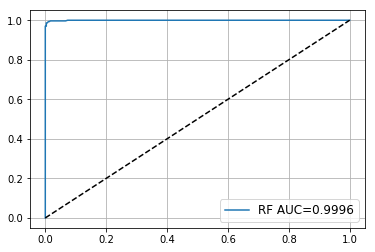

In [16]:
plot_roc_auc(y_val, y_pred, model_name='RF')

### Fine-tuning

Попробуем добиться лучшего качества модели путем ее дообучения

In [17]:
class ResnetFinetune(nn.Module):
    def __init__(self):
        super(ResnetFinetune, self).__init__()
        self.net = torchvision.models.resnet50(pretrained=True)
        self.net.fc = nn.Sequential(
            nn.Linear(self.net.fc.in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(256, 1)
        )

    def fresh_parameters(self):
        return self.net.fc.parameters()

    def forward(self, x):
        return self.net(x)

In [18]:
class CatsDogsDataset(torch.utils.data.Dataset):
    def __init__(self, fnames, labels, shape):
        self._fnames = fnames
        self._labels = labels
        self._shape = shape
        self._transform = torchvision.transforms.Compose([
            
            torchvision.transforms.Resize(shape),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __getitem__(self, index):
        fname = self._fnames[index]
        img = Image.open(fname).convert('RGB')
        img = self._transform(img)

        return img, self._labels[index]

    def __len__(self):
        return len(self._fnames)

In [19]:
def calculate_correct(y_true, y_pred):
    correct = (y_true == y_pred).squeeze()

    return correct.sum()

In [20]:
class Trainer:    
    def __init__(self, model, criterion, config, device='cuda'):
        self._model = model
        self._device = device
        self._criterion = criterion
        self._epochs = config['epochs']

        if config['only_top']:
            self._optimizer = torch.optim.Adam(self._model.fresh_parameters(), lr=config['lr'])
        else:
            self._optimizer = torch.optim.Adam(self._model.parameters(), lr=config['lr'])        

        self._model.to(self._device)

    def fit(self, train_loader, val_loader):
        for epoch in range(self._epochs):
            self._model.train()
            train_loss, train_accuracy = self._run_epoch(epoch, train_loader, is_training=True)
            print('Train. loss: {}, accuracy: {}'.format(train_loss, train_accuracy))
            
            self._model.eval()
            val_loss, val_accuracy = self._run_epoch(epoch, val_loader, is_training=False)
            print('Validation. loss: {}, accuracy: {}'.format(val_loss, val_accuracy))

    def _run_epoch(self, epoch, loader, is_training):
        loss = 0
        correct = 0
        if is_training:
            pbar = tqdm.tqdm(enumerate(loader), total=len(loader), desc='Epoch {}'.format(epoch), ncols=0)
        else:
            pbar = tqdm.tqdm(enumerate(loader), total=len(loader), desc='Val', ncols=0)
        
        for i, data in pbar:
            batch_loss, batch_correct = self._step(data, is_training)
            loss += batch_loss
            correct += batch_correct
        
        pbar.close()
        loss /= len(loader)
        accuracy = correct / len(loader.dataset)

        return loss, accuracy
    
    def _step(self, data, is_training=True):
        images = data[0].to(self._device)
        y_true = data[1].to(self._device)

        if is_training:
            self._optimizer.zero_grad()

        with torch.set_grad_enabled(is_training):
            y_pred = self._model(images)
            y_pred = y_pred.squeeze()
            loss = self._criterion(y_pred, y_true.float())

            if is_training:
                loss.backward()
                self._optimizer.step()
            
        probas = torch.sigmoid(y_pred)
        labels = (probas > 0.5).int()
        correct = calculate_correct(y_true=y_true, y_pred=labels)

        return loss.item(), correct.item()

Сначала будем учить только добавленные нами слои

In [21]:
model = ResnetFinetune()

In [22]:
batch_size = 8
num_workers = 16
shape = (224, 224)

train_dataset = CatsDogsDataset(train_fnames, y_train, shape)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=num_workers)

val_dataset = CatsDogsDataset(val_fnames, y_val, shape)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False, num_workers=num_workers)

In [23]:
config = {
    'lr': 1e-3,
    'epochs': 10,
    'only_top': True
}

trainer = Trainer(model, nn.BCEWithLogitsLoss(), config, device='cuda')
trainer.fit(train_loader, val_loader)

Epoch 0: 100% 175/175 [00:17<00:00,  9.99it/s]

Train. loss: 0.24778537273939166, accuracy: 0.9021428571428571



Val: 100% 75/75 [00:03<00:00, 20.65it/s]

Validation. loss: 0.07164867898449302, accuracy: 0.965



Epoch 1: 100% 175/175 [00:15<00:00, 11.34it/s]

Train. loss: 0.22794825091958046, accuracy: 0.915



Val: 100% 75/75 [00:03<00:00, 22.67it/s]

Validation. loss: 0.06944021385783951, accuracy: 0.9683333333333334



Epoch 2: 100% 175/175 [00:16<00:00, 10.59it/s]

Train. loss: 0.14804290534529302, accuracy: 0.9357142857142857



Val: 100% 75/75 [00:03<00:00, 24.62it/s]

Validation. loss: 0.061137053314596415, accuracy: 0.98



Epoch 3: 100% 175/175 [00:16<00:00, 10.54it/s]

Train. loss: 0.19095617460219988, accuracy: 0.9214285714285714



Val: 100% 75/75 [00:03<00:00, 22.04it/s]

Validation. loss: 0.11780826086178423, accuracy: 0.9416666666666667



Epoch 4: 100% 175/175 [00:17<00:00, 10.27it/s]

Train. loss: 0.17596098390540907, accuracy: 0.9328571428571428



Val: 100% 75/75 [00:03<00:00, 19.01it/s]

Validation. loss: 0.060930774739633, accuracy: 0.98



Epoch 5: 100% 175/175 [00:17<00:00, 10.12it/s]

Train. loss: 0.18434089341333934, accuracy: 0.9335714285714286



Val: 100% 75/75 [00:03<00:00, 19.60it/s]

Validation. loss: 0.054271285771392286, accuracy: 0.9833333333333333



Epoch 6: 100% 175/175 [00:16<00:00, 10.47it/s]

Train. loss: 0.12059623373406274, accuracy: 0.9535714285714286



Val: 100% 75/75 [00:03<00:00, 21.66it/s]

Validation. loss: 0.04924239155836403, accuracy: 0.985



Epoch 7: 100% 175/175 [00:08<00:00, 21.56it/s]

Train. loss: 0.14417325918695756, accuracy: 0.9442857142857143



Val: 100% 75/75 [00:01<00:00, 58.62it/s]

Validation. loss: 0.053371913465671245, accuracy: 0.975



Epoch 8: 100% 175/175 [00:09<00:00, 19.02it/s]

Train. loss: 0.1433140024988513, accuracy: 0.9414285714285714



Val: 100% 75/75 [00:01<00:00, 41.47it/s]

Validation. loss: 0.05723620865494013, accuracy: 0.9816666666666667



Epoch 9: 100% 175/175 [00:06<00:00, 27.08it/s]

Train. loss: 0.1121165022054421, accuracy: 0.9528571428571428



Val: 100% 75/75 [00:01<00:00, 61.11it/s]

Validation. loss: 0.09300291570369154, accuracy: 0.9683333333333334


In [24]:
class Evaluator:    
    def __init__(self, model, device='cuda'):
        self._model = model
        self._device = device

    def predict(self, loader):
        y_pred = []
        self._model.eval().to(self._device)
        
        with tqdm.tqdm(enumerate(loader), total=len(loader)) as pbar:
            for i, data in pbar:
                batch_pred = self._step(data)
                y_pred.append(batch_pred)
        
        return np.concatenate(y_pred)
    
    def _step(self, data, is_training=True):
        images = data[0].to(self._device)

        with torch.no_grad():
            y_pred = self._model(images)
        
        y_pred = y_pred.squeeze()
        y_pred = torch.sigmoid(y_pred)

        return y_pred.cpu().data.numpy()

In [25]:
evaluator = Evaluator(model, device='cuda')
y_pred = evaluator.predict(val_loader)

100%|██████████| 75/75 [00:01<00:00, 61.55it/s]


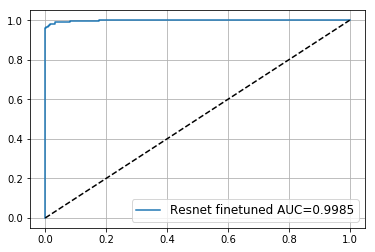

In [26]:
plot_roc_auc(y_val, y_pred, model_name='Resnet finetuned')

Теперь разморозим все веса и обучим несколько эпох с низким *learning rate*

In [27]:
config = {
    'lr': 1e-4,
    'epochs': 10,
    'only_top': False
}

trainer = Trainer(model, nn.BCEWithLogitsLoss(), config, device='cuda')
trainer.fit(train_loader, val_loader)

Epoch 0: 100% 175/175 [00:07<00:00, 23.29it/s]

Train. loss: 0.18902099441150702, accuracy: 0.9342857142857143



Val: 100% 75/75 [00:01<00:00, 60.92it/s]

Validation. loss: 0.07569044085170996, accuracy: 0.9683333333333334



Epoch 1: 100% 175/175 [00:07<00:00, 23.50it/s]

Train. loss: 0.08330785403418954, accuracy: 0.9735714285714285



Val: 100% 75/75 [00:01<00:00, 60.06it/s]

Validation. loss: 0.10580281167730694, accuracy: 0.9616666666666667



Epoch 2: 100% 175/175 [00:07<00:00, 23.58it/s]

Train. loss: 0.08512207465944811, accuracy: 0.97



Val: 100% 75/75 [00:01<00:00, 60.04it/s]

Validation. loss: 0.08198225962696597, accuracy: 0.9716666666666667



Epoch 3: 100% 175/175 [00:07<00:00, 23.56it/s]

Train. loss: 0.048803403805941344, accuracy: 0.9821428571428571



Val: 100% 75/75 [00:02<00:00, 37.48it/s]

Validation. loss: 0.11389998279133579, accuracy: 0.9566666666666667



Epoch 4: 100% 175/175 [00:17<00:00,  9.80it/s]

Train. loss: 0.08133836602642466, accuracy: 0.9778571428571429



Val: 100% 75/75 [00:03<00:00, 22.22it/s]

Validation. loss: 0.09400841382953028, accuracy: 0.9683333333333334



Epoch 5: 100% 175/175 [00:19<00:00,  8.95it/s]

Train. loss: 0.04701064771207582, accuracy: 0.9857142857142858



Val: 100% 75/75 [00:03<00:00, 19.12it/s]

Validation. loss: 0.0702537158979491, accuracy: 0.9816666666666667



Epoch 6: 100% 175/175 [00:20<00:00,  8.71it/s]

Train. loss: 0.025091064075906097, accuracy: 0.9914285714285714



Val: 100% 75/75 [00:02<00:00, 25.44it/s]

Validation. loss: 0.12389849128123993, accuracy: 0.95



Epoch 7: 100% 175/175 [00:18<00:00,  9.60it/s]

Train. loss: 0.020629134737246205, accuracy: 0.9921428571428571



Val: 100% 75/75 [00:03<00:00, 21.29it/s]

Validation. loss: 0.09539426567653815, accuracy: 0.97



Epoch 8: 100% 175/175 [00:20<00:00,  8.54it/s]

Train. loss: 0.02325049689430411, accuracy: 0.9928571428571429



Val: 100% 75/75 [00:02<00:00, 25.44it/s]

Validation. loss: 0.25250882597174495, accuracy: 0.9333333333333333



Epoch 9: 100% 175/175 [00:19<00:00,  9.07it/s]

Train. loss: 0.044986735980658395, accuracy: 0.9885714285714285



Val: 100% 75/75 [00:03<00:00, 22.29it/s]

Validation. loss: 0.12341284257165777, accuracy: 0.9666666666666667


In [28]:
evaluator = Evaluator(model, device='cuda')
y_pred = evaluator.predict(val_loader)

100%|██████████| 75/75 [00:03<00:00, 21.63it/s]


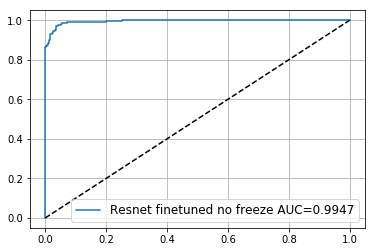

In [29]:
plot_roc_auc(y_val, y_pred, model_name='Resnet finetuned no freeze')

## Пишем свою CNN

### Типичные ошибки

Рассмотрим несколько примеров архитектур в связке с функциями потерь и попробуем найти какие-то проблемы

Для простоты будем использовать `nn.Sequential`

#### Задача 1

Предсказать стоимость автомобиля, на вход 100 признаков, описывающих автомобиль

In [30]:
model = nn.Sequential(
    nn.BatchNorm2d(num_features=100),
    nn.Linear(in_features=3, out_features=256),
    nn.Linear(in_features=256, out_features=256),
    nn.Linear(in_features=256, out_features=1)
)

loss = nn.MSELoss()

#### Задача 2

MNIST: Распознать рукописную цифру (0-9), на вход ч/б картинка 28x28 пикселей

In [31]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=512, kernel_size=(3, 3)),
    nn.ReLU(),
    nn.MaxPool2d((2, 2)),
    
    nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3, 3)),
    nn.ReLU(),
    nn.MaxPool2d((2, 2)),

    nn.Flatten(),
    nn.Linear(in_features=256, out_features=100),
    nn.ReLU(),
    nn.Dropout(0.2),
    
    nn.Linear(in_features=100, out_features=10),
    nn.Sigmoid(),
    nn.Dropout(0.1)
)

loss = nn.MSELoss()

#### Задача 3

Бинарная классификация изображений, на вход картинка RGB 100x100 пикселей

In [32]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(10, 10)),
    nn.Softmax(),
    nn.MaxPool2d((6, 6)),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(10, 10)),
    nn.Softmax(),
    nn.MaxPool2d((6, 6)),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(10, 10)),
    nn.Softmax(),
    nn.MaxPool2d((6, 6)),
    
    nn.Flatten(),
    nn.Linear(in_features=128, out_features=256),
    nn.Softmax(),
    nn.Dropout(0.8),
    nn.Linear(in_features=256, out_features=1)
)

loss = nn.BCEWithLogitsLoss()

### MNIST

Напишем свою сетку для решения задачи распознавания рукописных чисел

Датасет содержит ч/б изображения размером 28x28 пикселей

Также реализуем `early_stopping` и попробуем `lr_scheduler.ReduceLROnPlateau`

In [33]:
class MNISTTrainer:    
    def __init__(self, model, criterion, config, device='cuda'):
        self._model = model
        self._device = device
        self._criterion = criterion
        
        self._model.to(self._device)
        
        self._epochs = config['epochs']
        self._early_stopping = config['early_stopping']
              
        self._optimizer = torch.optim.Adam(self._model.parameters(), lr=config['lr'])
        self._scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self._optimizer,
            'min',
            factor=config['lr_reduce_rate'],
            patience=config['patience'],
            verbose=True,
        )
        
        self._best_loss = float('inf')
        self._best_epoch = -1

    def fit(self, train_loader, val_loader):
        for epoch in range(self._epochs):
            self._model.train()
            train_loss, train_accuracy = self._run_epoch(epoch, train_loader, is_training=True)
            print('Train. loss: {}, accuracy: {}'.format(train_loss, train_accuracy))
            
            self._model.eval()
            val_loss, val_accuracy = self._run_epoch(epoch, val_loader, is_training=False)
            print('Validation. loss: {}, accuracy: {}'.format(val_loss, val_accuracy))

            self._scheduler.step(val_loss)
           
            if self._best_loss > val_loss:
                self._best_loss = val_loss
                self._best_epoch = epoch

            if abs(self._best_epoch - epoch) > self._early_stopping:
                print('Early stopping. Epoch {}. Best epoch: {}, best {}: {}'.format(epoch, self._best_epoch))
                break
    
    def _run_epoch(self, epoch, loader, is_training):
        loss = 0
        correct = 0
        if is_training:
            pbar = tqdm.tqdm(enumerate(loader), total=len(loader), desc='Epoch {}'.format(epoch))
        else:
            pbar = enumerate(loader)
        
        for i, data in pbar:
            batch_loss, batch_correct = self._step(data, is_training)
            loss += batch_loss
            correct += batch_correct
        
        if is_training:
            pbar.close()

        loss /= len(loader)
        accuracy = correct / len(loader.dataset)

        return loss, accuracy
    
    def _step(self, data, is_training=True):
        metrics_values = {}
        images = data[0].to(self._device)
        y_true = data[1].to(self._device)

        if is_training:
            self._optimizer.zero_grad()

        with torch.set_grad_enabled(is_training):
            y_pred = self._model(images)
            y_pred = y_pred.squeeze()
            loss = self._criterion(y_pred, y_true)

            if is_training:
                loss.backward()
                self._optimizer.step()
            
        probas = torch.softmax(y_pred, dim=0)
        labels = probas.max(1)[1]
        correct = calculate_correct(y_true=y_true, y_pred=labels)

        return loss.item(), correct.item()

In [34]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d((2, 2))
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3))
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3))
        self.drop = nn.Dropout2d(p=0.5)

        self.classifier = nn.Linear(in_features=128, out_features=10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
    
        x = self.classifier(x)

        return x

In [35]:
model = MNISTModel()

In [38]:
batch_size = 64
num_workers = 0


train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(degrees=(-10, 10)),
    torchvision.transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=num_workers)

val_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])
val_dataset = torchvision.datasets.MNIST(root='data', train=False, download=False, transform=val_transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False, num_workers=num_workers)

9913344it [00:22, 449213.67it/s]                             


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



29696it [00:00, 152991.88it/s]                         


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



1649664it [00:03, 449096.37it/s]                             


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



5120it [00:00, 145398.90it/s]           


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [39]:
config = {
    'lr': 1e-3,
    'epochs': 10,
    'early_stopping': 5,
    'lr_reduce_rate': 0.5,
    'patience': 3
}

trainer = MNISTTrainer(model, nn.CrossEntropyLoss(), config, device='cuda')
trainer.fit(train_loader, val_loader)

Epoch 0: 100%|██████████| 938/938 [00:14<00:00, 66.44it/s]


Train. loss: 0.5654107260503876, accuracy: 0.6929
Validation. loss: 0.12951385536806503, accuracy: 0.928


Epoch 1: 100%|██████████| 938/938 [00:11<00:00, 78.94it/s]


Train. loss: 0.20541971304348663, accuracy: 0.8125333333333333
Validation. loss: 0.06578892760963481, accuracy: 0.9516


Epoch 2: 100%|██████████| 938/938 [00:12<00:00, 76.88it/s]


Train. loss: 0.155115340352813, accuracy: 0.83745
Validation. loss: 0.055052219955495314, accuracy: 0.9575


Epoch 3: 100%|██████████| 938/938 [00:11<00:00, 79.20it/s]


Train. loss: 0.12814172511217373, accuracy: 0.85595
Validation. loss: 0.048204503620616575, accuracy: 0.9662


Epoch 4: 100%|██████████| 938/938 [00:17<00:00, 54.28it/s]


Train. loss: 0.10926461348762867, accuracy: 0.8623833333333333
Validation. loss: 0.04156194742449046, accuracy: 0.9644


Epoch 5: 100%|██████████| 938/938 [00:23<00:00, 40.63it/s]


Train. loss: 0.09724246522437519, accuracy: 0.8686666666666667
Validation. loss: 0.03334266416550815, accuracy: 0.969


Epoch 6: 100%|██████████| 938/938 [00:25<00:00, 36.55it/s]


Train. loss: 0.08792565622752203, accuracy: 0.8802666666666666
Validation. loss: 0.03420238669708284, accuracy: 0.9739


Epoch 7: 100%|██████████| 938/938 [00:24<00:00, 38.05it/s]


Train. loss: 0.07999234328042469, accuracy: 0.8859333333333334
Validation. loss: 0.029978728971991296, accuracy: 0.9769


Epoch 8: 100%|██████████| 938/938 [00:25<00:00, 37.28it/s]


Train. loss: 0.07626914339058641, accuracy: 0.8914666666666666
Validation. loss: 0.0323032840074149, accuracy: 0.976


Epoch 9: 100%|██████████| 938/938 [00:21<00:00, 42.83it/s]


Train. loss: 0.0701247787607937, accuracy: 0.8942333333333333
Validation. loss: 0.029060680877267542, accuracy: 0.9748
